In [1]:
import torch
torch.__version__

'2.5.1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

###############################################
# Dataset for Original Images and 3-Channel Masks
###############################################

class LVCombinedDataset(Dataset):
    """
    Dataset that loads a single grayscale image from the image directory and its corresponding
    three masks from three sub-folders (Lobe_1, Lobe_2, Lobe_3) inside the mask directory.

    The grayscale image is replicated to create a 3-channel input.
    The masks from each subfolder are stacked to form a 3-channel mask.

    Args:
        image_dir (str): Directory containing original images.
        mask_parent_dir (str): Parent directory containing subfolders:
            - Lobe_1
            - Lobe_2
            - Lobe_3
        file_list (list of str): List of filenames (assumed to be identical in image_dir).
        target_size (tuple): (width, height) for resizing images and masks.
    """
    def __init__(self, image_dir, mask_parent_dir, file_list, target_size=(416, 480)):
        self.image_dir = image_dir
        self.mask1_dir = os.path.join(mask_parent_dir, "Lobe_1")
        self.mask2_dir = os.path.join(mask_parent_dir, "Lobe_2")
        self.mask3_dir = os.path.join(mask_parent_dir, "Lobe_3")
        self.file_list = file_list
        self.target_size = target_size  # (width, height)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]

        # Load original image (grayscale)
        img_path = os.path.join(self.image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not load image: {img_path}")
        # Resize and normalize the image
        img = cv2.resize(img, self.target_size)
        img = img.astype(np.float32) / 255.0
        # Replicate the grayscale image into 3 channels
        img = np.stack([img, img, img], axis=0)

        # Construct the mask filename by inserting '_gt' before the file extension.
        base, ext = os.path.splitext(filename)
        mask_filename = base + "_gt" + ext

        # Load the three mask images from their respective sub-folders
        mask1_path = os.path.join(self.mask1_dir, mask_filename)
        mask2_path = os.path.join(self.mask2_dir, mask_filename)
        mask3_path = os.path.join(self.mask3_dir, mask_filename)

        mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
        mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)
        mask3 = cv2.imread(mask3_path, cv2.IMREAD_GRAYSCALE)
        if mask1 is None or mask2 is None or mask3 is None:
            raise ValueError(f"Could not load one or more masks for file: {filename}")
        mask1 = cv2.resize(mask1, self.target_size)
        mask2 = cv2.resize(mask2, self.target_size)
        mask3 = cv2.resize(mask3, self.target_size)
        # Binarize the masks (assuming a threshold of 127)
        mask1 = (mask1 > 127).astype(np.float32)
        mask2 = (mask2 > 127).astype(np.float32)
        mask3 = (mask3 > 127).astype(np.float32)
        # Stack masks to form a 3-channel mask
        mask = np.stack([mask1, mask2, mask3], axis=0)

        # Convert to torch tensors
        img_tensor = torch.tensor(img, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        return img_tensor, mask_tensor

###############################################
# Prepare File Lists and DataLoaders
###############################################

# Define parent directories for images and masks
image_dir = r"E:\PROJECTS\Mini_Project\sem_6\img_480_416"
mask_parent_dir  = r"E:\PROJECTS\Mini_Project\sem_6\segmented_output"

# List files from the image_dir
supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tif')
all_files = [f for f in os.listdir(image_dir) if f.lower().endswith(supported_extensions)]

# Filter out files that do not have corresponding masks in all three subfolders.
valid_files = []
for f in all_files:
    base, ext = os.path.splitext(f)
    mask_filename = base + "_gt" + ext

    mask1_path = os.path.join(mask_parent_dir, "Lobe_1", mask_filename)
    mask2_path = os.path.join(mask_parent_dir, "Lobe_2", mask_filename)
    mask3_path = os.path.join(mask_parent_dir, "Lobe_3", mask_filename)
    if os.path.exists(mask1_path) and os.path.exists(mask2_path) and os.path.exists(mask3_path):
        valid_files.append(f)
    else:
        print(f"Skipping {f}: One or more mask files not found.")

print("Valid samples:", len(valid_files))

# Split file list into training and validation sets
train_files, val_files = train_test_split(valid_files, test_size=0.1, random_state=42)
print("Train samples:", len(train_files), "Validation samples:", len(val_files))

# Define target size as (width, height)
target_size = (416, 480)

# Create dataset objects
train_dataset = LVCombinedDataset(image_dir, mask_parent_dir, train_files, target_size=target_size)
val_dataset   = LVCombinedDataset(image_dir, mask_parent_dir, val_files, target_size=target_size)

# Custom collate function to filter out None values if necessary
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None, None
    return torch.utils.data.default_collate(batch)

# Create DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=0,
                          collate_fn=safe_collate)
val_loader   = DataLoader(val_dataset,
                          batch_size=4,
                          shuffle=False,
                          num_workers=0,
                          collate_fn=safe_collate)

# Check one batch
img, mask = next(iter(train_loader))
print("Input batch shape:", img.shape)  # Expected: [batch_size, 3, H, W]
print("Mask batch shape:", mask.shape)   # Expected: [batch_size, 3, H, W]


Valid samples: 2000
Train samples: 1800 Validation samples: 200
Input batch shape: torch.Size([4, 3, 480, 416])
Mask batch shape: torch.Size([4, 3, 480, 416])


In [4]:
print("Training Files:", train_files)
print("Validation Files:", val_files)


Training Files: ['patient0469_2CH_ED.png', 'patient0132_4CH_ED.png', 'patient0044_2CH_ES.png', 'patient0181_2CH_ED.png', 'patient0104_4CH_ED.png', 'patient0060_2CH_ES.png', 'patient0369_2CH_ED.png', 'patient0334_4CH_ES.png', 'patient0266_4CH_ES.png', 'patient0006_4CH_ES.png', 'patient0442_4CH_ED.png', 'patient0016_4CH_ES.png', 'patient0073_2CH_ES.png', 'patient0048_2CH_ED.png', 'patient0176_2CH_ES.png', 'patient0454_4CH_ED.png', 'patient0285_2CH_ES.png', 'patient0089_4CH_ED.png', 'patient0105_2CH_ED.png', 'patient0312_2CH_ES.png', 'patient0233_4CH_ED.png', 'patient0050_2CH_ED.png', 'patient0145_4CH_ES.png', 'patient0284_4CH_ED.png', 'patient0454_2CH_ES.png', 'patient0484_4CH_ED.png', 'patient0109_2CH_ES.png', 'patient0026_2CH_ED.png', 'patient0414_4CH_ED.png', 'patient0099_4CH_ED.png', 'patient0485_4CH_ED.png', 'patient0056_2CH_ED.png', 'patient0419_4CH_ES.png', 'patient0375_2CH_ES.png', 'patient0447_2CH_ED.png', 'patient0087_2CH_ED.png', 'patient0257_4CH_ES.png', 'patient0223_2CH_ED.p

In [5]:
img, mask = next(iter(train_loader))
img.shape, mask.shape

(torch.Size([4, 3, 480, 416]), torch.Size([4, 3, 480, 416]))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        # Ensure the dimensions match (in case of odd input sizes)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class nnUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, base_filters)
        self.down1 = DownBlock(base_filters, base_filters * 2)
        self.down2 = DownBlock(base_filters * 2, base_filters * 4)
        self.down3 = DownBlock(base_filters * 4, base_filters * 8)
        self.down4 = DownBlock(base_filters * 8, base_filters * 16)
        self.up1 = UpBlock(base_filters * 16, base_filters * 8)
        self.up2 = UpBlock(base_filters * 8, base_filters * 4)
        self.up3 = UpBlock(base_filters * 4, base_filters * 2)
        self.up4 = UpBlock(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x_up1 = self.up1(x5, x4)
        x_up2 = self.up2(x_up1, x3)
        x_up3 = self.up3(x_up2, x2)
        x_up4 = self.up4(x_up3, x1)
        pre_output = x_up4  # Features before final convolution
        output = self.out_conv(pre_output)
        return output, pre_output

In [20]:
# Initialize the model
model = nnUNet(in_channels=3, out_channels=3).to(device)
print(model)

nnUNet(
  (in_conv): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): DownBlock(
    (block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), str

In [21]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

#[batch_size, 3, height, width]
summary(model, input_size=[4, 3, 416, 480])

Layer (type:depth-idx)                             Output Shape              Param #
nnUNet                                             [4, 3, 416, 480]          --
├─ConvBlock: 1-1                                   [4, 32, 416, 480]         --
│    └─Sequential: 2-1                             [4, 32, 416, 480]         --
│    │    └─Conv2d: 3-1                            [4, 32, 416, 480]         896
│    │    └─InstanceNorm2d: 3-2                    [4, 32, 416, 480]         --
│    │    └─LeakyReLU: 3-3                         [4, 32, 416, 480]         --
│    │    └─Conv2d: 3-4                            [4, 32, 416, 480]         9,248
│    │    └─InstanceNorm2d: 3-5                    [4, 32, 416, 480]         --
│    │    └─LeakyReLU: 3-6                         [4, 32, 416, 480]         --
├─DownBlock: 1-2                                   [4, 64, 208, 240]         --
│    └─Sequential: 2-2                             [4, 64, 208, 240]         --
│    │    └─MaxPool2d: 3-7     

In [22]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_accuracy(outputs, masks):
    """
    Computes pixel-wise accuracy for binary segmentation.

    Args:
        outputs (Tensor or tuple): Raw logits from the network. If tuple,
                                   assumes the first element is the main output.
        masks (Tensor): Ground truth binary masks.

    Returns:
        float: Pixel accuracy.
    """
    # If deep supervision is enabled, use only the main output.
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs

    # Convert logits to probabilities and then to binary predictions.
    probs = torch.sigmoid(main_output)
    preds = (probs > 0.5).float()
    correct = (preds == masks).float().sum()
    total = masks.numel()
    return correct / total

def compute_dice_score(outputs, masks, smooth=1e-8):
    """
    Computes Dice score for binary segmentation.

    Args:
        outputs (Tensor or tuple): Raw logits from the network. If tuple,
                                   assumes the first element is the main output.
        masks (Tensor): Ground truth binary masks.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice score.
    """
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs

    probs = torch.sigmoid(main_output)
    intersection = (probs * masks).sum()
    dice_score = (2. * intersection + smooth) / (probs.sum() + masks.sum() + smooth)
    return dice_score

def train_step(model, dataloader, loss_fn, optimizer, device):
    """Train for one epoch and return average loss, dice score, and accuracy."""
    model.train()
    cur_loss = 0.0
    total_dice = 0.0
    total_acc = 0.0
    processed_batches = 0

    for batch in dataloader:
        if batch is None:
            continue  # Skip empty batches

        imgs, masks = batch
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # Ensure outputs is a tensor, not a tuple
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Ensure masks and outputs have the same shape
        if outputs.shape != masks.shape:
            masks = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode="nearest")

        # Compute loss
        loss = loss_fn(outputs, masks)

        # Compute Dice Score
        preds = torch.sigmoid(outputs)
        intersection = (preds * masks).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))
        dice = (2. * intersection + 1e-8) / (union + 1e-8)
        dice = dice.mean().item()

        # Compute Accuracy
        preds_bin = (preds > 0.5).float()
        correct = (preds_bin == masks).sum()
        total = torch.numel(masks)
        accuracy = correct / total

        # Backward pass
        loss.backward()
        optimizer.step()

        cur_loss += loss.item()
        total_dice += dice
        total_acc += accuracy.item()
        processed_batches += 1

    if processed_batches == 0:
        return float("inf"), 0.0, 0.0

    return cur_loss / processed_batches, total_dice / processed_batches, total_acc / processed_batches


In [23]:
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

def compute_accuracy(outputs, masks):
    """
    Computes pixel-wise accuracy for binary segmentation.
    If deep supervision is enabled (i.e., outputs is a tuple), uses only the main output.
    """
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs
    probs = torch.sigmoid(main_output)
    preds = (probs > 0.5).float()
    correct = (preds == masks).float().sum()
    total = masks.numel()
    return correct / total

def compute_dice_score(outputs, masks, smooth=1e-8):
    """
    Computes the Dice score for binary segmentation.
    If deep supervision is enabled (i.e., outputs is a tuple), uses only the main output.
    """
    if isinstance(outputs, tuple):
        main_output = outputs[0]
    else:
        main_output = outputs
    probs = torch.sigmoid(main_output)
    intersection = (probs * masks).sum()
    dice_score = (2. * intersection + smooth) / (probs.sum() + masks.sum() + smooth)
    return dice_score

def test_step(model, dataloader, loss_fn, device):
    """Evaluate the model and return average loss, dice score, and accuracy."""
    model.eval()
    cur_loss = 0.0
    total_dice = 0.0
    total_acc = 0.0
    valid_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue  # Skip empty batches

            imgs, masks = batch
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            # Ensure outputs is a tensor, not a tuple
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            # Ensure masks and outputs have the same shape
            if outputs.shape != masks.shape:
                masks = torch.nn.functional.interpolate(masks, size=outputs.shape[2:], mode="nearest")

            # Compute loss
            loss = loss_fn(outputs, masks)

            # Compute Dice Score
            preds = torch.sigmoid(outputs)
            intersection = (preds * masks).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))
            dice = (2. * intersection + 1e-8) / (union + 1e-8)
            dice = dice.mean().item()

            # Compute Accuracy
            preds_bin = (preds > 0.5).float()
            correct = (preds_bin == masks).sum()
            total = torch.numel(masks)
            accuracy = correct / total

            cur_loss += loss.item()
            total_dice += dice
            total_acc += accuracy.item()
            valid_batches += 1

    if valid_batches == 0:
        return float("inf"), 0.0, 0.0

    return cur_loss / valid_batches, total_dice / valid_batches, total_acc / valid_batches


In [24]:
import torch
import torch.nn as nn

class HybridLoss(nn.Module):
    """
    A combination of Binary Cross-Entropy (BCE) loss and Dice loss for segmentation tasks.
    """
    def __init__(self, bce_weight=1.0, dice_weight=1.0):
        super(HybridLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, preds, targets):
        """
        Compute the hybrid loss.

        Args:
            preds (torch.Tensor): Model predictions (logits).
            targets (torch.Tensor): Ground truth masks.

        Returns:
            torch.Tensor: Weighted sum of BCE and Dice loss.
        """
        # Compute BCE Loss
        bce = self.bce_loss(preds, targets)

        # Compute Dice Loss
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        intersection = (preds * targets).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice_loss = 1 - (2. * intersection + 1e-8) / (union + 1e-8)
        dice_loss = dice_loss.mean()

        # Weighted sum of BCE and Dice loss
        return self.bce_weight * bce + self.dice_weight * dice_loss


In [25]:
import os
from tqdm.auto import tqdm
import torch

import os

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, device, epochs, model_save_path):
    """Train and evaluate the model while storing loss, dice scores, and accuracy for visualization."""
    results = {
        "train_loss": [],
        "train_dice": [],
        "train_acc": [],
        "val_loss": [],
        "val_dice": [],
        "val_acc": []
    }

    best_val_loss = float("inf")

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        train_loss, train_dice, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss, val_dice, val_acc = test_step(model, val_dataloader, loss_fn, device)

        print(
            f"Epoch {epoch + 1}: "
            f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val Acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_dice"].append(train_dice)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_dice"].append(val_dice)
        results["val_acc"].append(val_acc)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
            torch.save(model.state_dict(), model_save_path)
            print(f"✅ New best model saved at {model_save_path} with Val Loss: {val_loss:.4f}")

        # Update learning rate
        if scheduler:
            scheduler.step(val_loss)

    return results


In [ ]:
model_save_path = r"/content/sample_data/unet_lv50.pth"

# Optimizer and Scheduler Configuration
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Start Training
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    loss_fn=HybridLoss(bce_weight=1.0, dice_weight=1.0),
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=50,
    model_save_path=model_save_path
)


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.2475, Train Dice: 0.2512, Train Acc: 0.8314 | Val Loss: 1.0765, Val Dice: 0.3135, Val Acc: 0.9567
✅ New best model saved at /content/sample_data/unet_lv.pth with Val Loss: 1.0765
Epoch 2: Train Loss: 0.9799, Train Dice: 0.3451, Train Acc: 0.9685 | Val Loss: 0.8696, Val Dice: 0.3966, Val Acc: 0.9706
✅ New best model saved at /content/sample_data/unet_lv.pth with Val Loss: 0.8696
Epoch 3: Train Loss: 0.7873, Train Dice: 0.4322, Train Acc: 0.9756 | Val Loss: 0.6907, Val Dice: 0.4866, Val Acc: 0.9777
✅ New best model saved at /content/sample_data/unet_lv.pth with Val Loss: 0.6907
Epoch 4: Train Loss: 0.6324, Train Dice: 0.5195, Train Acc: 0.9791 | Val Loss: 0.5589, Val Dice: 0.5682, Val Acc: 0.9803
✅ New best model saved at /content/sample_data/unet_lv.pth with Val Loss: 0.5589
Epoch 5: Train Loss: 0.5112, Train Dice: 0.6000, Train Acc: 0.9811 | Val Loss: 0.4530, Val Dice: 0.6450, Val Acc: 0.9807
✅ New best model saved at /content/sample_data/unet_lv.pth with Val Los

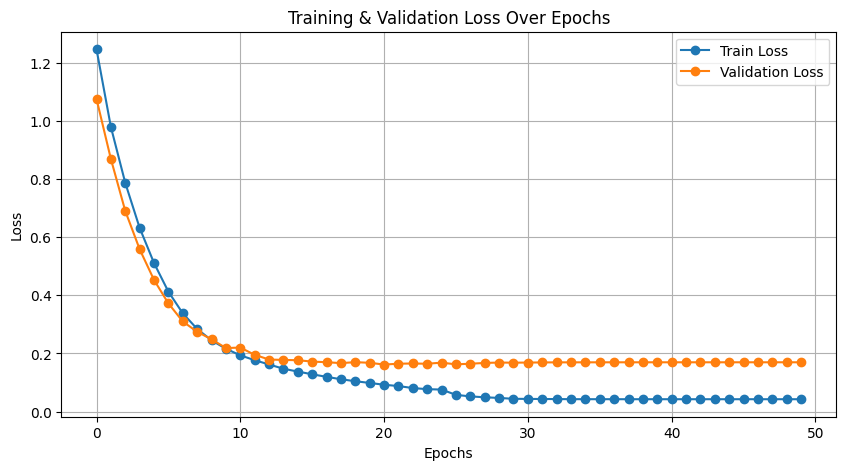

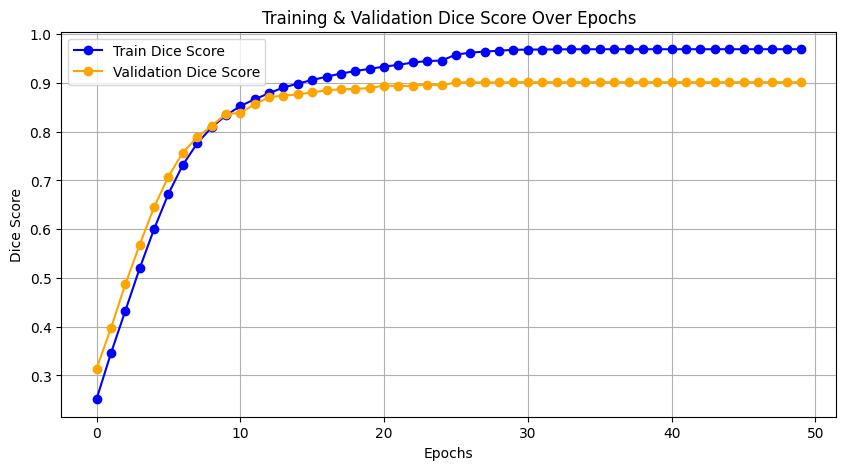

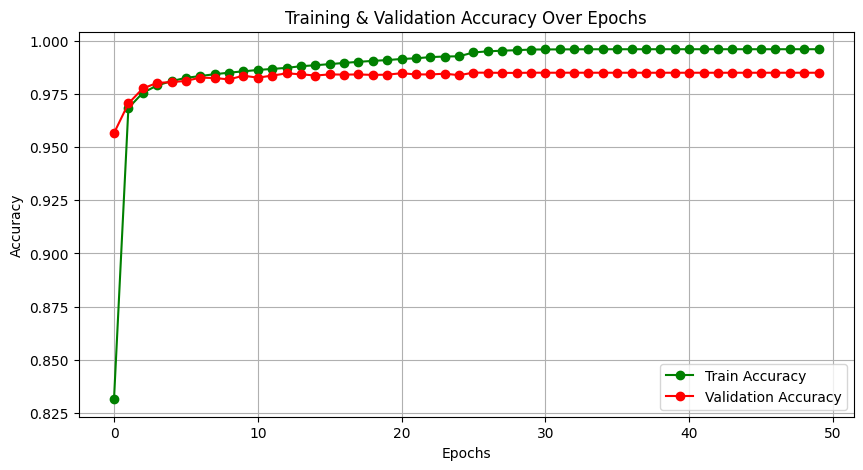

In [27]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(model_results["train_loss"], label="Train Loss", marker='o')
plt.plot(model_results["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Dice Score
plt.figure(figsize=(10, 5))
plt.plot(model_results["train_dice"], label="Train Dice Score", marker='o', color='blue')
plt.plot(model_results["val_dice"], label="Validation Dice Score", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Dice Score")
plt.title("Training & Validation Dice Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(model_results["train_acc"], label="Train Accuracy", marker='o', color='green')
plt.plot(model_results["val_acc"], label="Validation Accuracy", marker='o', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


In [24]:
import torch
import torch.nn.functional as F

def lrp_0(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-0 rule:
      R_j <- Σ_i ( z_ji / (Σ_j z_ji + ε) ) * R_i
    where z_ji = w_ji * a_j.
    """
    # Forward pass
    z = layer(input_activation)
    
    # Compute the "distribution" factor
    s = relevance / (z + epsilon)
    
    # Backprop relevance
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_epsilon(layer, input_activation, relevance, epsilon=1e-6):
    """
    LRP-ε rule (epsilon rule):
      R_j <- Σ_i ( z_ji + ε·sign(z_ji) ) / (Σ_j z_ji + ε·sign(Σ_j z_ji)) * R_i
    We implement a simplified version:
      1) Forward pass to get z
      2) Add small epsilon * sign(z) to stabilize
      3) Distribute relevance
      4) Gradient w.r.t. original z
    """
    z = layer(input_activation)
    
    # Add a sign-based stabilizer
    sign_z = torch.where(z >= 0, torch.ones_like(z), -torch.ones_like(z))
    z_eps = z + epsilon * sign_z
    
    # Distribute relevance
    s = relevance / z_eps
    # Use gradient w.r.t. z (not z_eps), so we pass `z` below:
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return input_activation * c


def lrp_z_plus(layer, input_activation, relevance, epsilon=1e-6):
    """
    z+ (ε) rule:
      Only the positive contributions are considered in z.
      R_j <- Σ_i ( z_ji^+ / (Σ_j z_ji^+ + ε) ) * R_i
    """
    # Forward pass
    z = layer(input_activation)
    
    # Keep only positive contributions
    z_plus = torch.clamp(z, min=0)
    
    # Distribute relevance based on z+ only
    s = relevance / (z_plus + epsilon)
    
    # We take gradient wrt z_plus to zero-out negative paths
    c = torch.autograd.grad(z_plus, input_activation, s, retain_graph=True)[0]
    
    # Multiply by positive part of input as well (common variant)
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_gamma(layer, input_activation, relevance, gamma=0.5, epsilon=1e-6):
    """
    LRP-γ rule:
      Scales positive weights by (1+γ) to boost positive contributions.
    """
    # Temporarily modify layer weights for the forward pass
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = W_original.clone()
        # Scale only positive weights by (1 + gamma)
        W_modified[W_modified > 0] = W_modified[W_modified > 0] * (1.0 + gamma)
        layer.weight.data = W_modified
    
    # Forward pass with scaled weights
    z_mod = layer(input_activation)
    z_mod_plus = torch.clamp(z_mod, min=0)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_mod_plus + epsilon)
    c = torch.autograd.grad(z_mod_plus, input_activation, s, retain_graph=True)[0]
    
    return torch.clamp(input_activation, min=0) * torch.clamp(c, min=0)


def lrp_alpha_beta(layer, input_activation, relevance, alpha=0.95, beta=0.5):
    """
    α-β rule (from your original code).
    """
    z = layer(input_activation)
    pos_z = torch.clamp(z, min=0)
    neg_z = torch.clamp(z, max=0)
    s = relevance / (pos_z + neg_z + 1e-6)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    return alpha * input_activation * torch.clamp(c, min=0) - beta * input_activation * torch.clamp(c, max=0)


def lrp_flat(layer, input_activation, relevance, seg_mask=None):
    """
    Flat rule + optional masking.
    """
    # 1. Forward pass (ignored, just for shape consistency).
    z = layer(input_activation)
    
    # 2. Compute total relevance (sum over output).
    B, outC, outH, outW = z.shape
    B, inC, H, W = input_activation.shape
    total_relevance = relevance.view(B, -1).sum(dim=1, keepdim=True)  # [B,1]
    
    # 3. Distribute uniformly across all input pixels.
    num_input_elements = inC * H * W
    flat_relevance = total_relevance / float(num_input_elements)
    flat_relevance = flat_relevance.view(B, 1, 1, 1).expand(B, inC, H, W)

    # 4. Optional: multiply by segmentation mask to blank out background
    if seg_mask is not None:
        # seg_mask should have shape [B, 1, H, W] or [B, inC, H, W].
        # If needed, broadcast seg_mask to match [B, inC, H, W].
        if seg_mask.shape[1] == 1 and inC > 1:
            seg_mask = seg_mask.expand(-1, inC, -1, -1)
        flat_relevance = flat_relevance * seg_mask
    
    return flat_relevance



def lrp_w_squared(layer, input_activation, relevance, epsilon=1e-6):
    """
    w² rule:
      Relevance is distributed proportionally to w².
    """
    W_original = layer.weight.data
    with torch.no_grad():
        W_modified = (W_original**2).clone()
        layer.weight.data = W_modified
    
    z_w2 = layer(input_activation)
    
    # Restore original weights
    layer.weight.data = W_original
    
    # Distribute relevance
    s = relevance / (z_w2 + epsilon)
    c = torch.autograd.grad(z_w2, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


def lrp_zB(layer, input_activation, relevance, l=0.0, h=1.0, epsilon=1e-6):
    """
    z^B rule (bounded rule).
    """
    z = layer(input_activation)
    
    W = layer.weight
    W_plus = torch.clamp(W, min=0)
    W_minus = torch.clamp(W, max=0)
    
    x_plus = torch.clamp(input_activation, min=0)
    x_minus = torch.clamp(input_activation, max=0)
    
    # zB = z - l·(x^+ * w^+) - h·(x^- * w^-)
    z_b = z
    z_b = z_b - l * F.conv2d(x_plus, W_plus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    z_b = z_b - h * F.conv2d(x_minus, W_minus, bias=None,
                             stride=layer.stride, padding=layer.padding)
    
    s = relevance / (z_b + epsilon)
    c = torch.autograd.grad(z, input_activation, s, retain_graph=True)[0]
    
    return input_activation * c


In [25]:
# Suppose this is code3.py

lrp_0, lrp_epsilon, lrp_z_plus, lrp_gamma,
lrp_alpha_beta, lrp_flat, lrp_w_squared, lrp_zB

lrp_functions = {
    "LRP-0": lrp_0,
    "epsilon": lrp_epsilon,     # <-- Added here
    "z-plus": lrp_z_plus,
    "gamma": lrp_gamma,
    "alpha-beta": lrp_alpha_beta,
    "flat": lrp_flat,
    "w-squared": lrp_w_squared,
    "zB": lrp_zB
}


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_seg_mask_on_image(image_np, mask_np, alpha=0.5, mask_color=(1, 0, 0)):
    """
    Overlays a binary mask on top of the original image.
      image_np: [H, W, 3], float in [0,1]
      mask_np:  [H, W], float (0 or 1) or something that can be thresholded
      alpha:    blending factor
      mask_color: (R, G, B) in [0,1]
    """
    # Ensure mask is binary or in [0,1]
    mask_bin = (mask_np > 0.5).astype(np.float32)
    
    # Convert mask to 3D color
    mask_3d = np.stack([mask_bin * c for c in mask_color], axis=-1)  # [H, W, 3]
    
    # Blend
    out = (1 - alpha) * image_np + alpha * mask_3d
    return np.clip(out, 0, 1)


def overlay_heatmap_on_image(image_np, heatmap_np, alpha=0.5, cmap='jet'):
    """
    Overlays a continuous heatmap (0..1) on top of the original image.
      image_np:   [H, W, 3], float in [0,1]
      heatmap_np: [H, W], float in [0,1]
      alpha:      blending factor
      cmap:       a matplotlib colormap name
    """
    cm = plt.get_cmap(cmap)
    colored_hm = cm(heatmap_np)[:, :, :3]  # RGBA -> take only RGB
    
    # Blend
    out = (1 - alpha) * image_np + alpha * colored_hm
    return np.clip(out, 0, 1)


C:\Users\rohit\AppData\Local\Temp\ipykernel_11516\2951060902.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

Segmentation output stats: min = 1.461996475882188e-06 max = 0.9999865293502808 mean = 0.09887898713350296


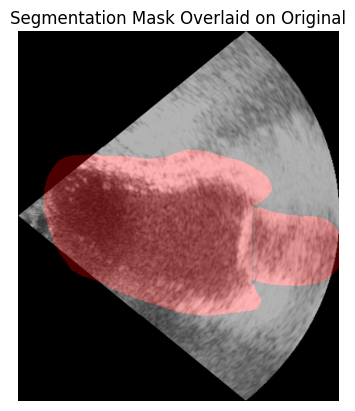


=== LRP Rule: LRP-0 ===
Relevance stats: min = -1.256540060043335 max = 3.0438709259033203 mean = -0.039858538657426834


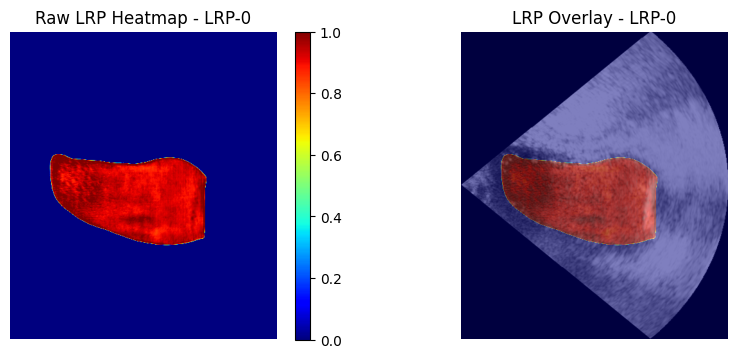


=== LRP Rule: epsilon ===
Relevance stats: min = -1.2564115524291992 max = 3.0438709259033203 mean = -0.03985853120684624


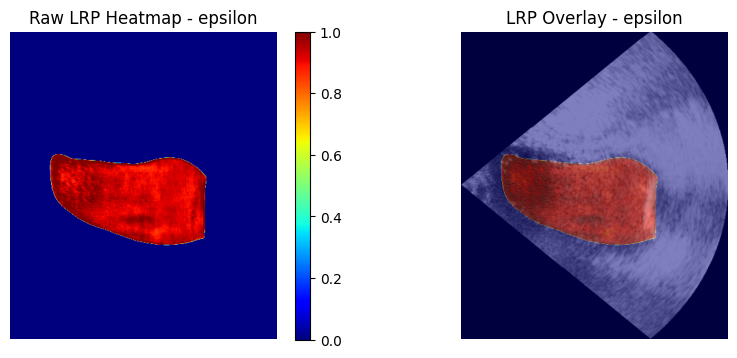


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 19.73598861694336 mean = 0.03738575056195259


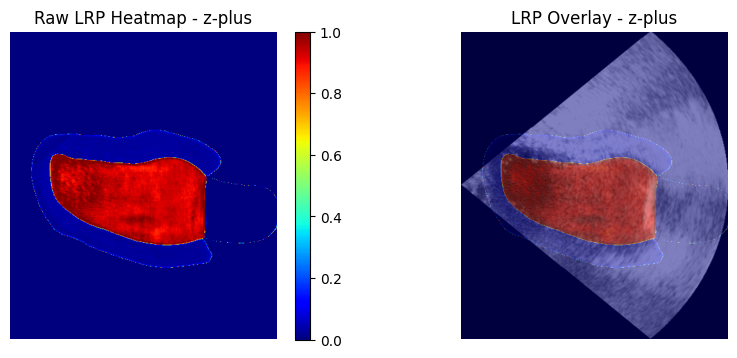


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 20.953128814697266 mean = 0.024200260639190674


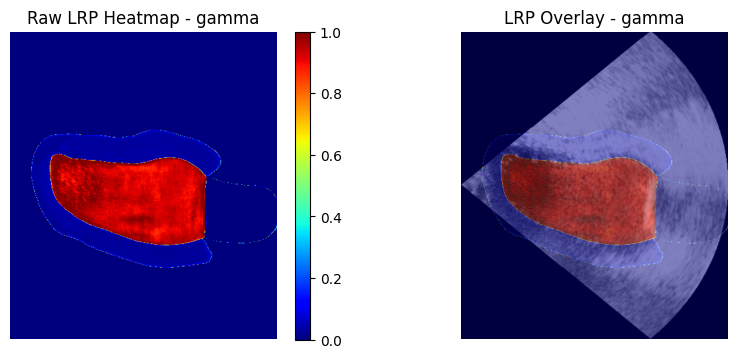


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 27.11554718017578 mean = 0.15915851294994354


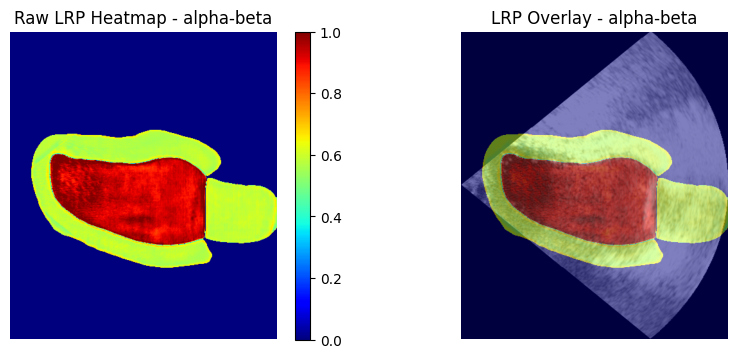


=== LRP Rule: flat ===
Relevance stats: min = -0.24011994898319244 max = 0.0 mean = -0.07080700993537903


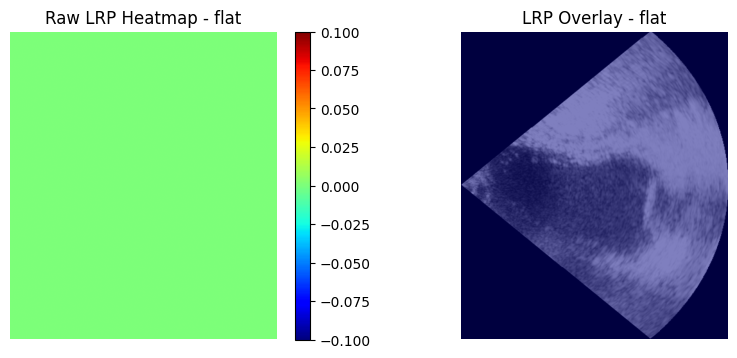


=== LRP Rule: w-squared ===
Relevance stats: min = -0.520301103591919 max = 0.8258551359176636 mean = 0.028572317212820053


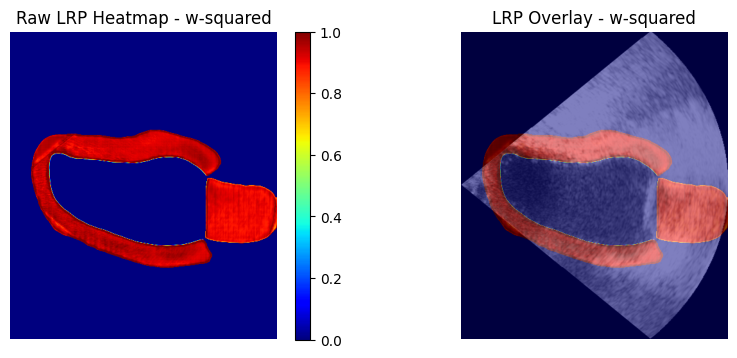


=== LRP Rule: zB ===
Relevance stats: min = -1.0587894916534424 max = 15.754262924194336 mean = -0.03967410326004028


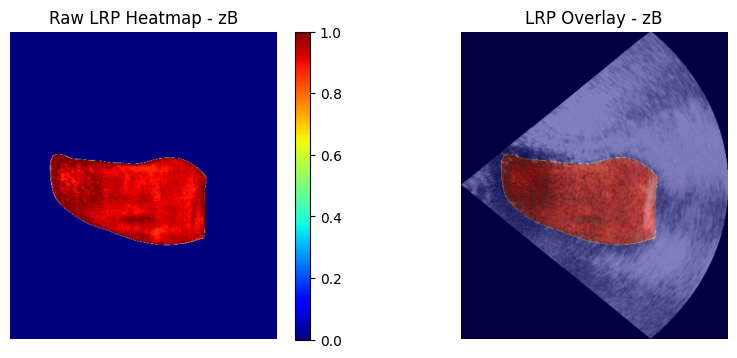

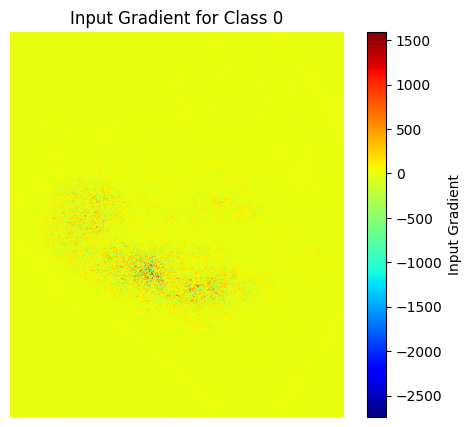

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\models\best_model_dice.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\img_480_416\patient0001_2CH_ED.png"

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))  # [1,3,H,W]
    image.requires_grad = True

    output, pre_output = model(image)
    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # Convert original image for visualization (shape: [H,W,3])
    orig_img_np = image[0].permute(1, 2, 0).detach().cpu().numpy()
    orig_img_np = np.clip(orig_img_np, 0, 1)

    # ----------------------------
    # 2. Visualize Segmentation Mask Overlay
    # ----------------------------
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()

    # ----------------------------
    # 3. Run Each LRP Rule and Visualize Results
    # ----------------------------
    class_idx = 0  # Choose the output channel (class) to analyze
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        relevance = output.detach().clone()  # [B, out_channels, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B,1,H,W]

        # For the flat rule, pass the segmentation mask so that irrelevant areas are blanked out.
        if rule_name == "flat":
            relevance = lrp_fn(model.out_conv, pre_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # If multiple channels, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # Optionally, apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)

        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()

    # ----------------------------
    # 4. (Optional) Visualize Input Gradient
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


C:\Users\rohit\AppData\Local\Temp\ipykernel_14688\411361160.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

Segmentation output stats: min = 4.3745298171415925e-05 max = 0.9999890327453613 mean = 0.06740052998065948


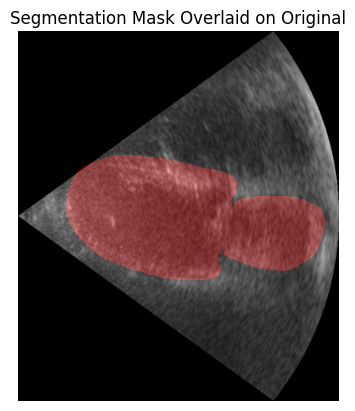


=== LRP Rule: LRP-0 ===
Relevance stats: min = -10.796990394592285 max = 2.190223217010498 mean = -0.03363889828324318


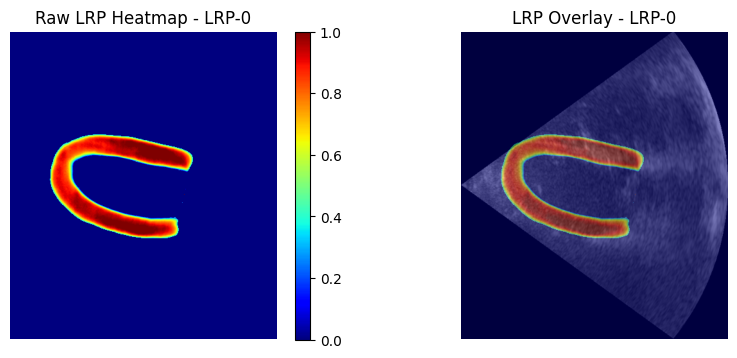


=== LRP Rule: epsilon ===
Relevance stats: min = -10.796990394592285 max = 2.190223217010498 mean = -0.03363889455795288


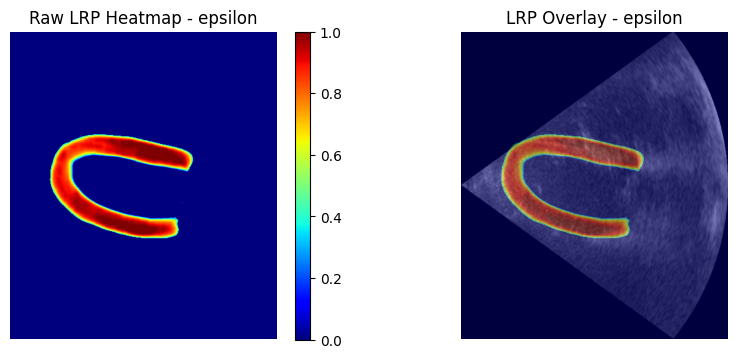


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 25.94450569152832 mean = 0.016983643174171448


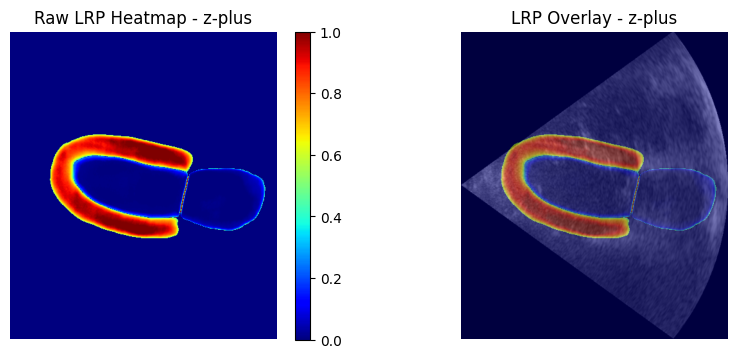


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 227.41465759277344 mean = 0.012962419539690018


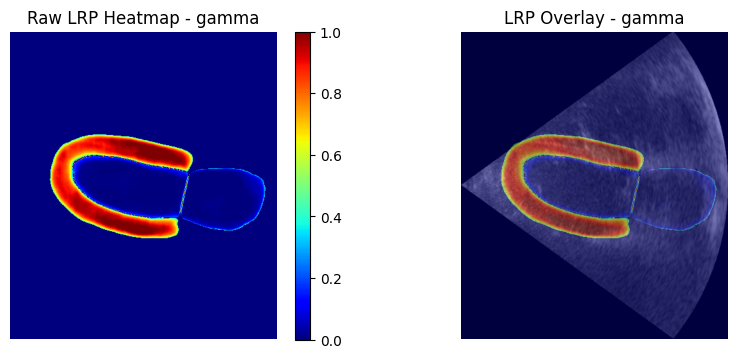


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 39.42334747314453 mean = 0.07954583317041397


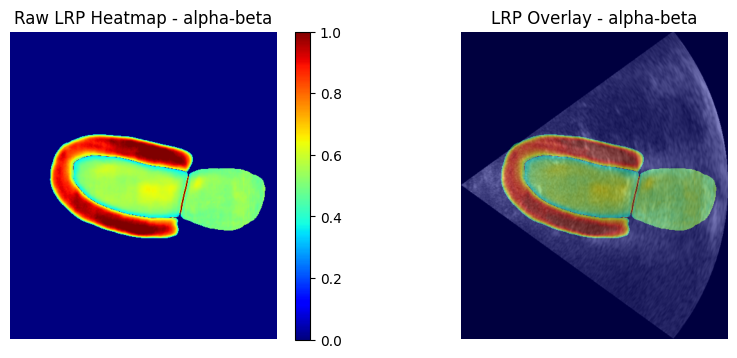


=== LRP Rule: flat ===
Relevance stats: min = -0.18810875713825226 max = 0.0 mean = -0.03637070953845978


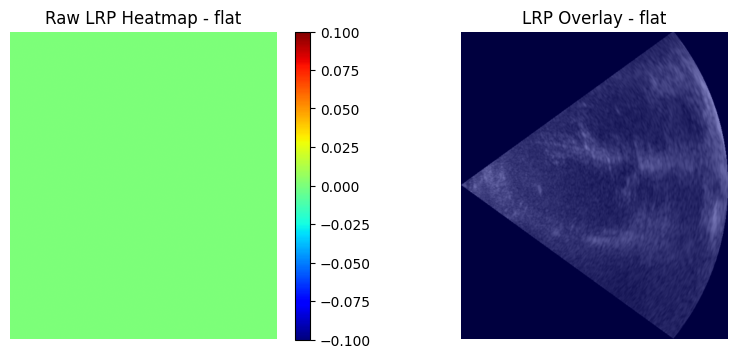


=== LRP Rule: w-squared ===
Relevance stats: min = -0.5701038837432861 max = 0.8485385179519653 mean = 0.03945663198828697


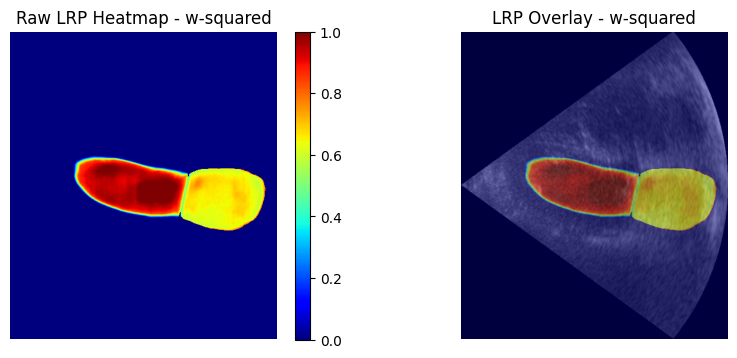


=== LRP Rule: zB ===
Relevance stats: min = -10.21481704711914 max = 10.15438175201416 mean = -0.03336184099316597


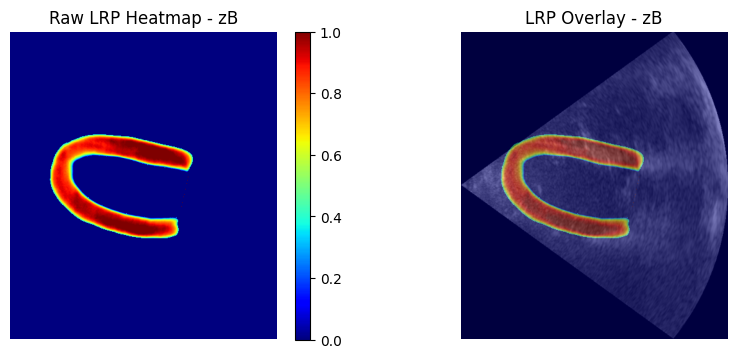

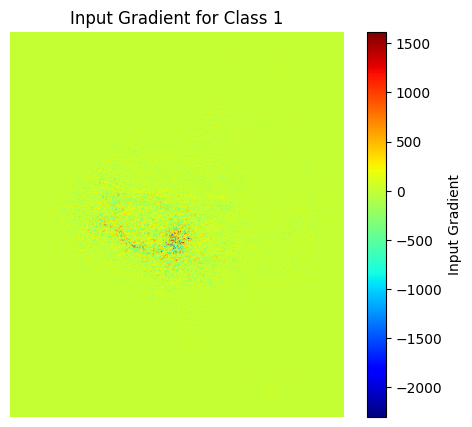

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\models\unet_lv50.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\img_480_416\patient0498_4CH_ED.png"

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))  # [1,3,H,W]
    image.requires_grad = True

    output, pre_output = model(image)
    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # Convert original image for visualization (shape: [H,W,3])
    orig_img_np = image[0].permute(1, 2, 0).detach().cpu().numpy()
    orig_img_np = np.clip(orig_img_np, 0, 1)

    # ----------------------------
    # 2. Visualize Segmentation Mask Overlay
    # ----------------------------
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()

    # ----------------------------
    # 3. Run Each LRP Rule and Visualize Results
    # ----------------------------
    class_idx = 1  # Choose the output channel (class) to analyze
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        relevance = output.detach().clone()  # [B, out_channels, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B,1,H,W]

        # For the flat rule, pass the segmentation mask so that irrelevant areas are blanked out.
        if rule_name == "flat":
            relevance = lrp_fn(model.out_conv, pre_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # If multiple channels, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # Optionally, apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)

        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()

    # ----------------------------
    # 4. (Optional) Visualize Input Gradient
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


C:\Users\rohit\AppData\Local\Temp\ipykernel_14688\1739738151.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

Segmentation output stats: min = 4.3745298171415925e-05 max = 0.9999890327453613 mean = 0.06740052998065948


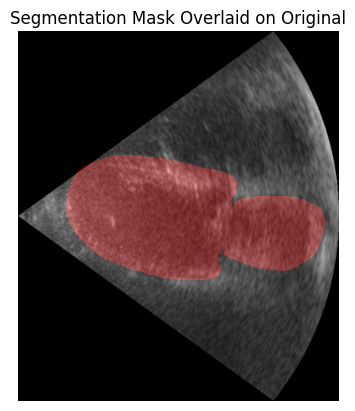


=== LRP Rule: LRP-0 ===
Relevance stats: min = -100.09834289550781 max = 29.836305618286133 mean = -0.08049685508012772


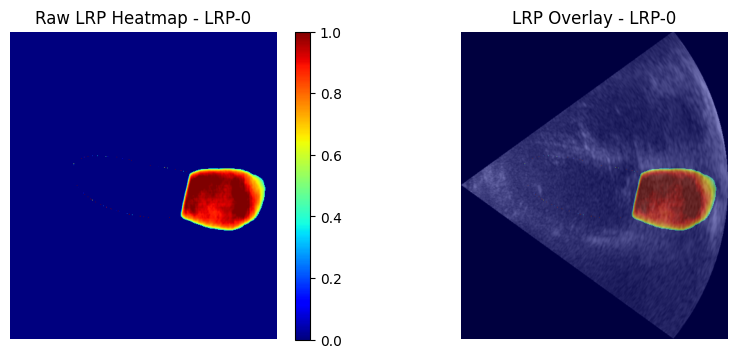


=== LRP Rule: epsilon ===
Relevance stats: min = -100.09834289550781 max = 29.822731018066406 mean = -0.08049694448709488


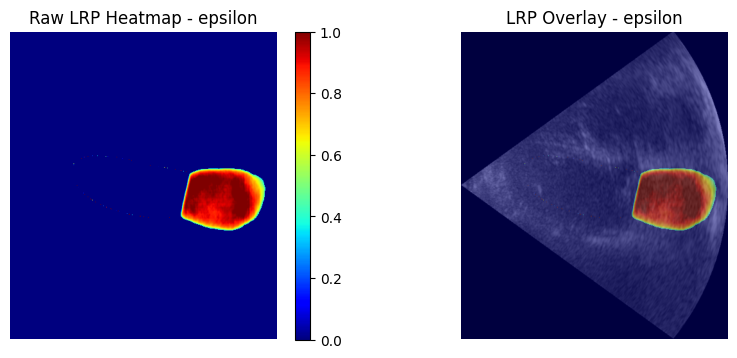


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 492.386474609375 mean = 0.02282438986003399


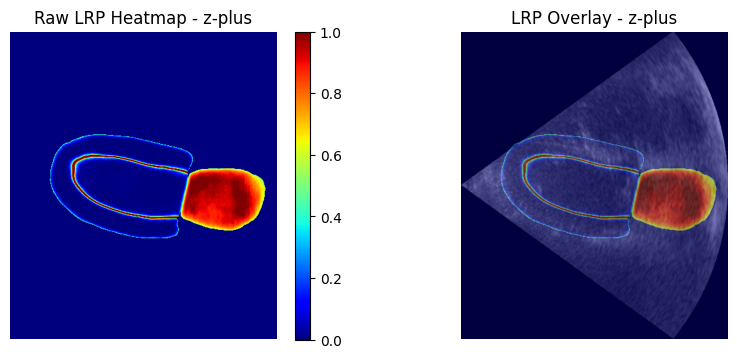


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 1337.765869140625 mean = 0.022466212511062622


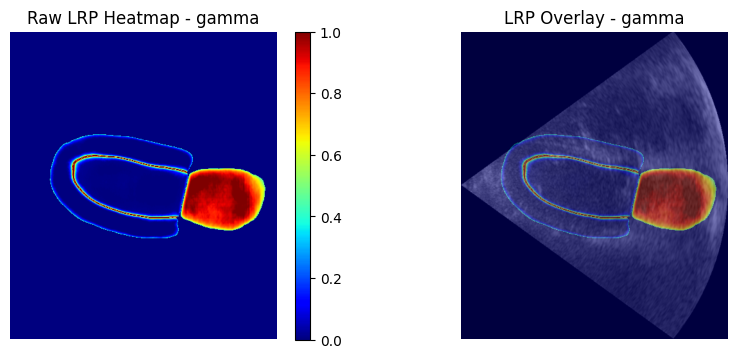


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 739.3829345703125 mean = 0.11064469814300537


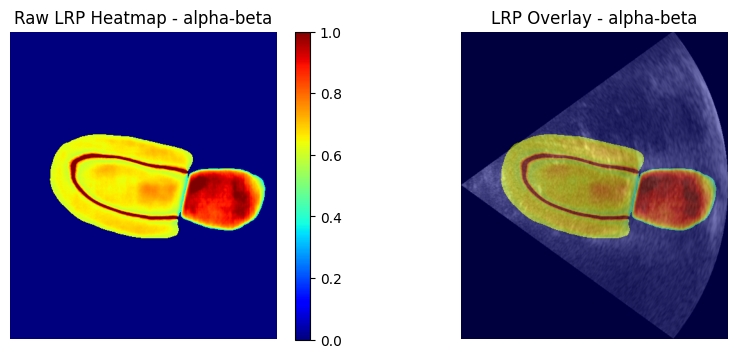


=== LRP Rule: flat ===
Relevance stats: min = -0.2099931389093399 max = 0.0 mean = -0.04060203954577446


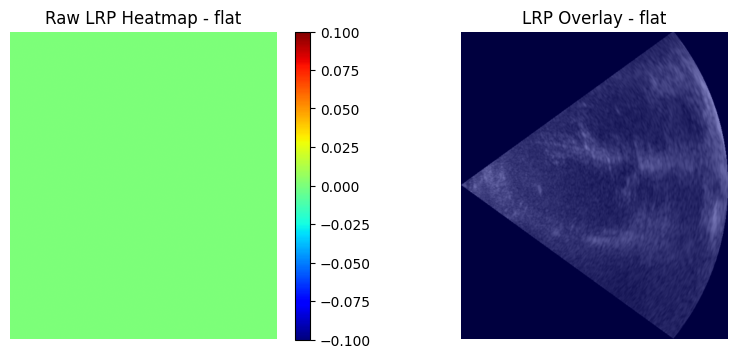


=== LRP Rule: w-squared ===
Relevance stats: min = -0.5461868047714233 max = 0.9615440964698792 mean = 0.07104285061359406


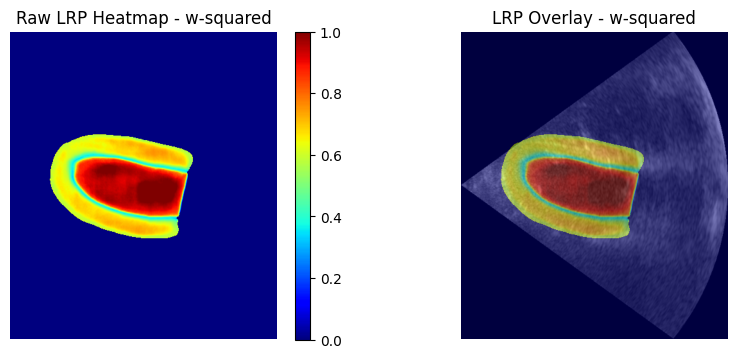


=== LRP Rule: zB ===
Relevance stats: min = -54.50447082519531 max = 274.1985778808594 mean = -0.07778257131576538


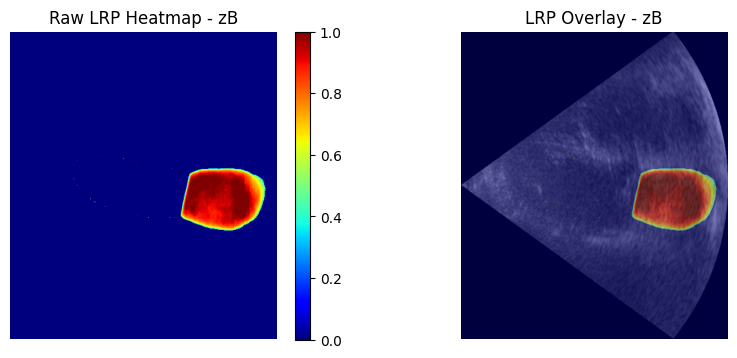

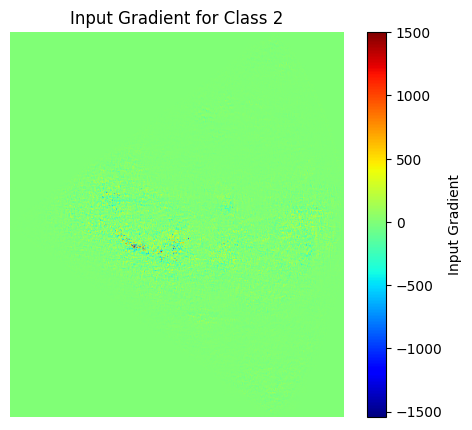

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\models\unet_lv50.pth"
    image_path = r"E:\PROJECTS\Mini_Project\sem_6\img_480_416\patient0498_4CH_ED.png"

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()

    image = load_image(image_path, target_size=(416, 480))  # [1,3,H,W]
    image.requires_grad = True

    output, pre_output = model(image)
    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # Convert original image for visualization (shape: [H,W,3])
    orig_img_np = image[0].permute(1, 2, 0).detach().cpu().numpy()
    orig_img_np = np.clip(orig_img_np, 0, 1)

    # ----------------------------
    # 2. Visualize Segmentation Mask Overlay
    # ----------------------------
    seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
    seg_mask_np = seg_mask[0, 0].detach().cpu().numpy()
    overlaid_seg = overlay_seg_mask_on_image(orig_img_np, seg_mask_np, alpha=0.3, mask_color=(1, 0, 0))
    plt.figure()
    plt.imshow(overlaid_seg)
    plt.title("Segmentation Mask Overlaid on Original")
    plt.axis("off")
    plt.show()

    # ----------------------------
    # 3. Run Each LRP Rule and Visualize Results
    # ----------------------------
    class_idx = 2  # Choose the output channel (class) to analyze
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")
        relevance = output.detach().clone()  # [B, out_channels, H, W]
        relevance = lrp_class_specific(relevance, class_idx)  # [B,1,H,W]

        # For the flat rule, pass the segmentation mask so that irrelevant areas are blanked out.
        if rule_name == "flat":
            relevance = lrp_fn(model.out_conv, pre_output, relevance, seg_mask=seg_mask)
        else:
            relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # If multiple channels, average them.
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # Optionally, apply the segmentation mask to the relevance.
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)
        print("Relevance stats:", 
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # Normalize and prepare the heatmap.
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        hm_min, hm_max = heatmap.min(), heatmap.max()
        if hm_max > hm_min:
            heatmap = (heatmap - hm_min) / (hm_max - hm_min)
        else:
            heatmap = np.zeros_like(heatmap)

        overlaid_hm = overlay_heatmap_on_image(orig_img_np, heatmap, alpha=0.5, cmap='jet')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(heatmap, cmap='jet')
        plt.colorbar()
        plt.title(f"Raw LRP Heatmap - {rule_name}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlaid_hm)
        plt.title(f"LRP Overlay - {rule_name}")
        plt.axis("off")
        plt.show()

    # ----------------------------
    # 4. (Optional) Visualize Input Gradient
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()


C:\Users\rohit\AppData\Local\Temp\ipykernel_16236\4017905737.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

Segmentation output stats: min = 1.7226315321750008e-05 max = 0.9999580383300781 mean = 0.09804603457450867

=== LRP Rule: LRP-0 ===
Relevance stats: min = -1.7932124137878418 max = 0.7161081433296204 mean = -0.05914219096302986


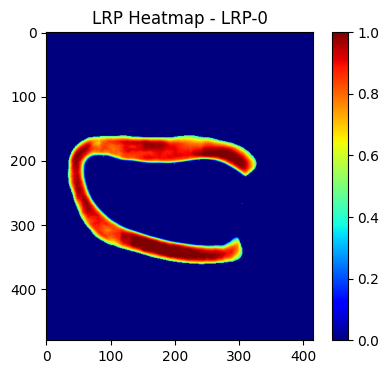


=== LRP Rule: z-plus ===
Relevance stats: min = 0.0 max = 9.773712158203125 mean = 0.022295912727713585


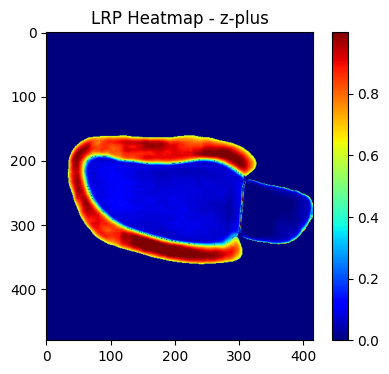


=== LRP Rule: gamma ===
Relevance stats: min = 0.0 max = 44.875885009765625 mean = 0.01554887555539608


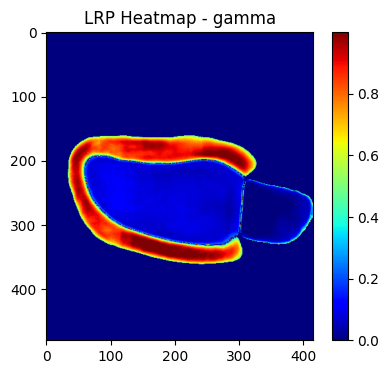


=== LRP Rule: alpha-beta ===
Relevance stats: min = 0.0 max = 14.709480285644531 mean = 0.10302823036909103


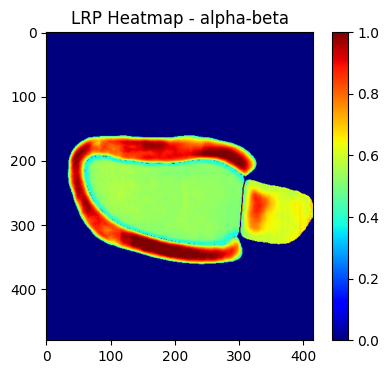


=== LRP Rule: flat ===
Relevance stats: min = -0.18777376413345337 max = -0.0 mean = -0.05321948230266571


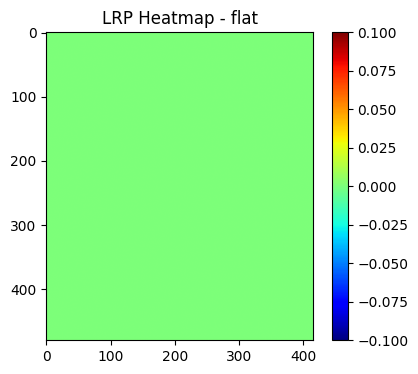


=== LRP Rule: w-squared ===
Relevance stats: min = -0.5072789192199707 max = 0.7700701951980591 mean = 0.06507835537195206


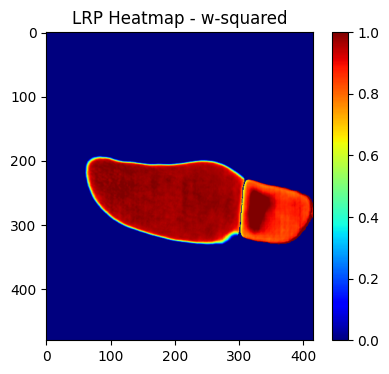


=== LRP Rule: zB ===
Relevance stats: min = -2.863222122192383 max = 12.566108703613281 mean = -0.05900644138455391


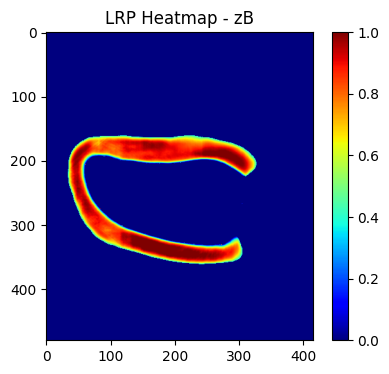

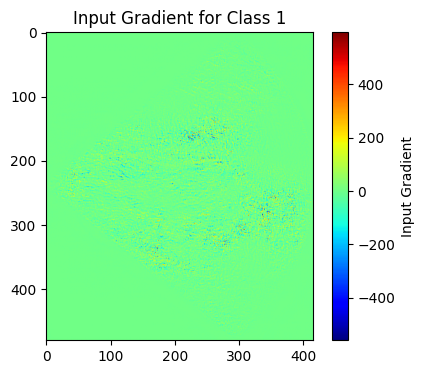

In [29]:
def main():
    # ----------------------------
    # 1. Setup & Model Loading
    # ----------------------------
    model_path = r'E:\PROJECTS\Mini_Project\sem_6\models\unet_lv50.pth'
    image_path = r'E:\PROJECTS\Mini_Project\sem_6\img_480_416\patient0001_2CH_ED.png'

    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    # Load the image
    image = load_image(image_path, target_size=(416, 480))
    image.requires_grad = True

    # Forward pass (do it once)
    output, pre_output = model(image)
    segmentation_output = torch.sigmoid(output)

    print("Segmentation output stats:",
          "min =", segmentation_output.min().item(),
          "max =", segmentation_output.max().item(),
          "mean =", segmentation_output.mean().item())

    # ----------------------------
    # 2. Define your LRP functions
    # ----------------------------
    lrp_functions = {
        "LRP-0": lrp_0,
        "z-plus": lrp_z_plus,
        "gamma": lrp_gamma,
        "alpha-beta": lrp_alpha_beta,  # your existing alpha-beta
        "flat": lrp_flat,
        "w-squared": lrp_w_squared,
        "zB": lrp_zB
    }

    # ----------------------------
    # 3. Run each LRP rule
    # ----------------------------
    class_idx = 1  # or whichever output channel you want to analyze
    # We'll do a loop over each rule, compute the heatmap, and display
    for rule_name, lrp_fn in lrp_functions.items():
        print(f"\n=== LRP Rule: {rule_name} ===")

        # (a) Start with the model output as the initial relevance
        relevance = output.detach().clone()  # shape: [B, out_channels, H, W]

        # (b) Extract class-specific relevance
        relevance = lrp_class_specific(relevance, class_idx)

        # (c) Apply the chosen LRP rule on the final conv layer
        #     This matches your alpha-beta usage:
        relevance = lrp_fn(model.out_conv, pre_output, relevance)

        # (d) Collapse the channel dimension if needed
        #     (some rules might keep multi-channel relevance)
        if relevance.shape[1] > 1:
            relevance = relevance.mean(dim=1, keepdim=True)

        # (e) Optionally apply a segmentation mask
        seg_mask = (segmentation_output.mean(dim=1, keepdim=True) > 0.3).float()
        relevance = apply_segmentation_mask(relevance, seg_mask, threshold=0.3)

        # (f) Print stats
        print("Relevance stats:",
              "min =", relevance.min().item(),
              "max =", relevance.max().item(),
              "mean =", relevance.mean().item())

        # (g) Normalize and visualize
        heatmap = relevance.detach().squeeze().cpu().numpy()
        p99 = np.percentile(heatmap, 99)
        heatmap = np.clip(heatmap, 0, p99)
        # Simple min-max normalization
        hm_min, hm_max = heatmap.min(), heatmap.max()
        heatmap = (heatmap - hm_min) / (hm_max - hm_min + 1e-8)

        plt.figure(figsize=(5, 4))
        plt.imshow(heatmap, cmap='jet')
        plt.title(f"LRP Heatmap - {rule_name}")
        plt.colorbar()
        plt.show()

    # ----------------------------
    # 4. (Optional) Visualize simple input gradient
    # ----------------------------
    model.zero_grad()
    output[0, class_idx].sum().backward(retain_graph=True)
    grad = image.grad.data[0, 0, :, :].cpu().numpy()
    plt.figure(figsize=(5, 4))
    plt.imshow(grad, cmap='jet')
    plt.colorbar(label="Input Gradient")
    plt.title(f"Input Gradient for Class {class_idx}")
    plt.show()

if __name__ == "__main__":
    main()


C:\Users\rohit\AppData\Local\Temp\ipykernel_3012\1941034426.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

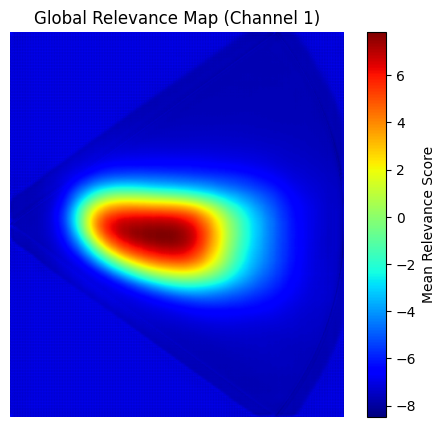

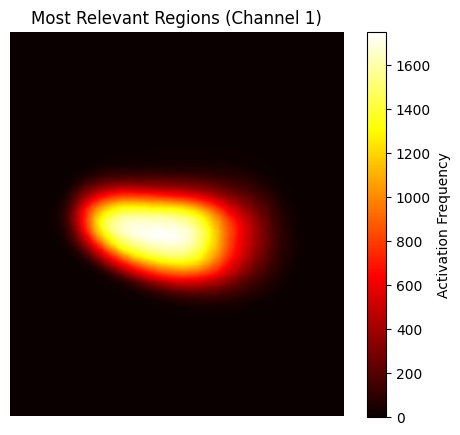

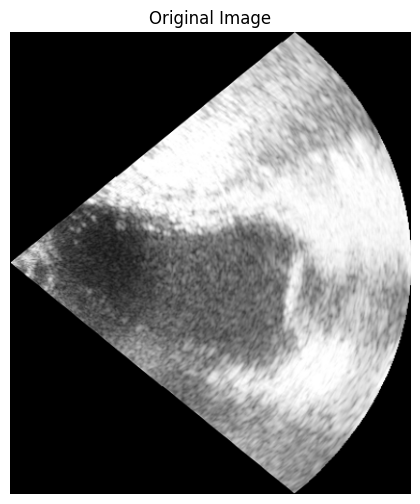

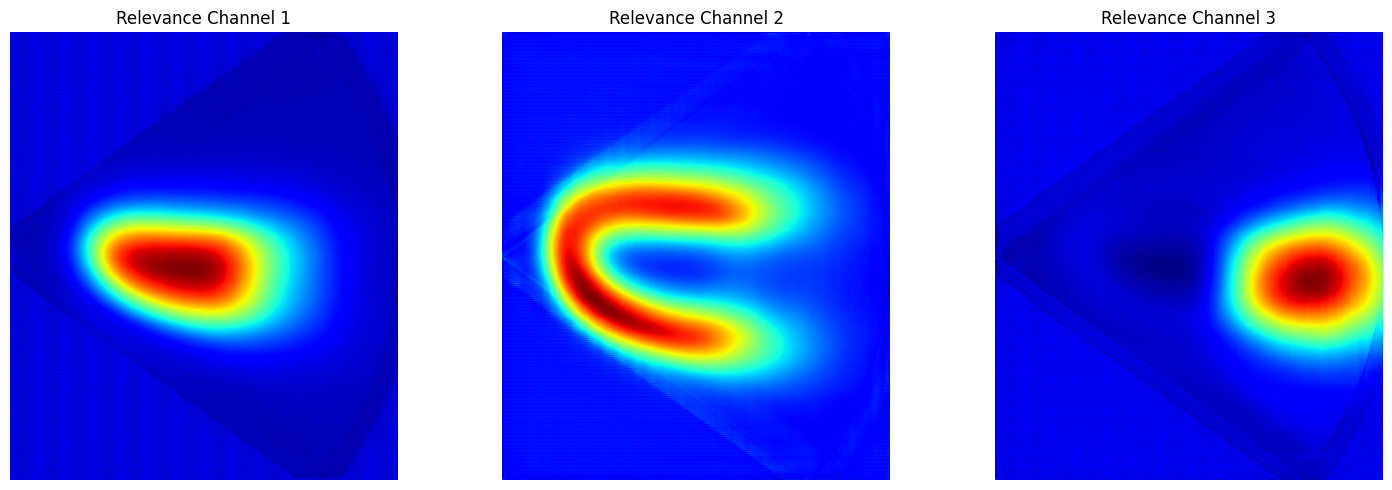

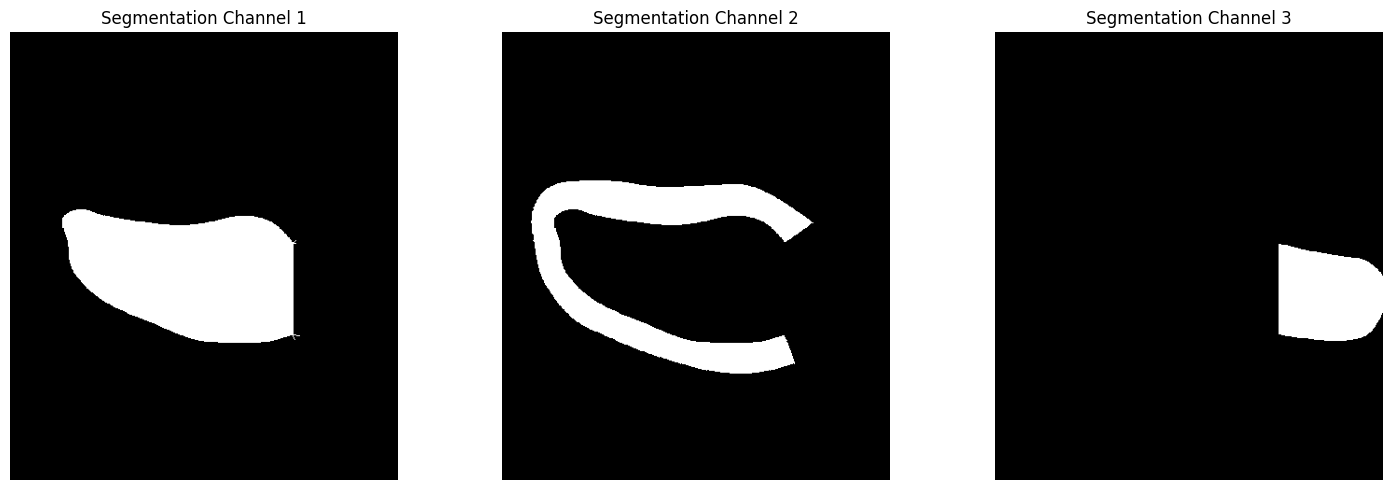

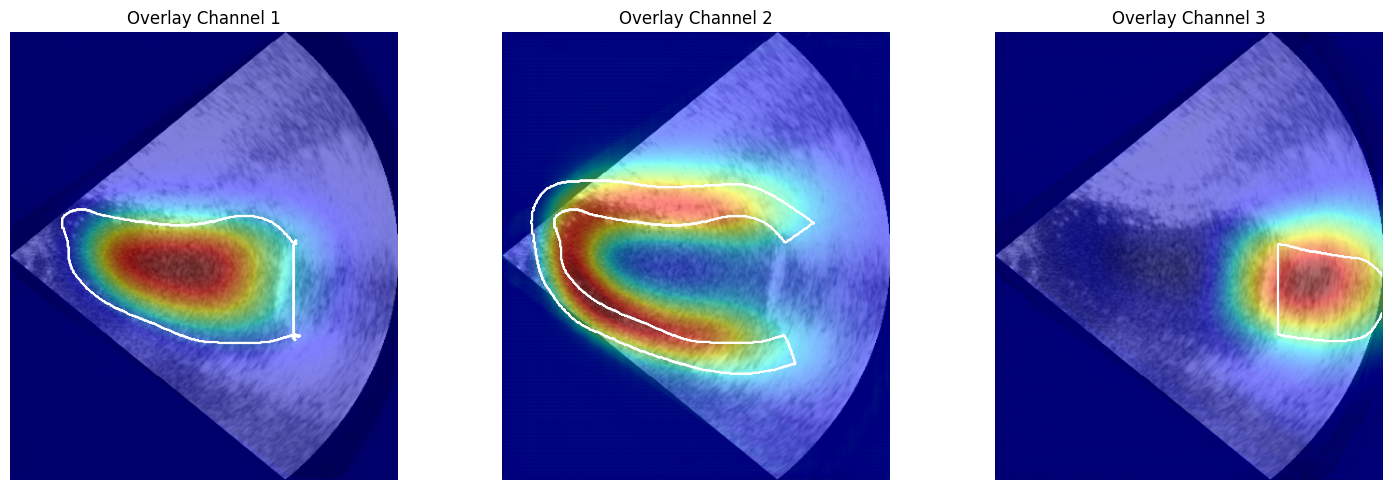

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

############################################
# 1. Custom Dataset for images and masks   #
############################################

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, seg_dir, transform=None, seg_transform=None):
        """
        Args:
            img_dir (str): Path to the folder with images.
            seg_dir (str): Path to the folder containing subfolders for segmentation masks.
                           Each subfolder (e.g., Lobe_1, Lobe_2, Lobe_3) contains segmentation masks.
            transform (callable, optional): Transform to be applied on an image.
            seg_transform (callable, optional): Transform to be applied on a segmentation mask.
        """
        self.img_dir = img_dir
        self.img_files = sorted(os.listdir(img_dir))
        # List subdirectories in seg_dir (e.g., Lobe_1, Lobe_2, Lobe_3)
        self.seg_subdirs = sorted([
            os.path.join(seg_dir, d)
            for d in os.listdir(seg_dir)
            if os.path.isdir(os.path.join(seg_dir, d))
        ])
        self.transform = transform
        self.seg_transform = seg_transform

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        # Load the image
        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Create the corresponding segmentation filename.
        # For example: "patient0001_2CH_ED.png" -> "patient0001_2CH_ED_gt.png"
        base, ext = os.path.splitext(img_filename)
        seg_filename = base + "_gt" + ext
        
        # Load the segmentation masks from each subfolder and stack them along the channel dimension.
        seg_masks = []
        for subdir in self.seg_subdirs:
            seg_path = os.path.join(subdir, seg_filename)
            seg = Image.open(seg_path).convert('L')  # Grayscale mask
            if self.seg_transform:
                seg = self.seg_transform(seg)
            # After transform, seg is expected to have shape (1, H, W)
            seg_masks.append(seg)
        # Concatenate the masks to form a multi-channel segmentation tensor.
        segmentation = torch.cat(seg_masks, dim=0)
        return image, segmentation

############################################
# 2. Model Definition (nnUNet)             #
############################################

# Basic convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# Down-sampling block
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.block(x)

# Up-sampling block
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    def forward(self, x, skip):
        x = self.up(x)
        # Resize if needed
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# nnUNet model definition
class nnUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=32):
        super().__init__()
        self.in_conv = ConvBlock(in_channels, base_filters)
        self.down1 = DownBlock(base_filters, base_filters * 2)
        self.down2 = DownBlock(base_filters * 2, base_filters * 4)
        self.down3 = DownBlock(base_filters * 4, base_filters * 8)
        self.down4 = DownBlock(base_filters * 8, base_filters * 16)
        self.up1 = UpBlock(base_filters * 16, base_filters * 8)
        self.up2 = UpBlock(base_filters * 8, base_filters * 4)
        self.up3 = UpBlock(base_filters * 4, base_filters * 2)
        self.up4 = UpBlock(base_filters * 2, base_filters)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)
    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x_up1 = self.up1(x5, x4)
        x_up2 = self.up2(x_up1, x3)
        x_up3 = self.up3(x_up2, x2)
        x_up4 = self.up4(x_up3, x1)
        pre_output = x_up4
        output = self.out_conv(pre_output)
        return output, pre_output
    def relprop(self, relevance, alpha=1):
        """
        Dummy relprop implementation.
        In practice, implement layer-wise relevance propagation here.
        """
        return relevance

############################################
# 3. LRP and Processing Functions          #
############################################

def compute_lrp(output, class_idx, model):
    """Applies LRP for the given model output and class index."""
    relevance = output.clone()
    # Set relevance only for the target class (simplified approach)
    relevance[:, class_idx] = output[:, class_idx]
    relevance = model.relprop(relevance, alpha=1)  # Apply LRP
    return relevance

def process_dataset(dataset, model, device):
    """Processes images from the dataset to generate relevance maps."""
    relevance_maps = []
    # Disable gradient computations during inference.
    with torch.no_grad():
        for img, _ in dataset:  # segmentation masks are not used for forward pass
            img = img.to(device).unsqueeze(0)  # add batch dimension
            output, _ = model(img)  # forward pass; output shape: (1, out_channels, H, W)
            # For segmentation, choose the class with highest activation.
            class_idx = torch.argmax(output, dim=1).view(-1)[0].item()  
            relevance = compute_lrp(output, class_idx, model)
            # Detach before converting to NumPy.
            relevance_maps.append(relevance.detach().cpu().numpy())
    return np.array(relevance_maps)

def aggregate_relevance(relevance_maps):
    """Computes the mean relevance map across the dataset and visualizes it."""
    mean_relevance = np.mean(relevance_maps, axis=0)  # shape: (1, channels, H, W)
    # If more than one channel, select channel 0 for display.
    if mean_relevance.shape[1] == 1:
        mean_relevance_img = mean_relevance[0, 0]
    else:
        mean_relevance_img = mean_relevance[0, 0]  # select channel 0
    plt.figure(figsize=(6, 5))
    plt.imshow(mean_relevance_img, cmap="jet")
    plt.colorbar(label="Mean Relevance Score")
    plt.title("Global Relevance Map (Channel 1)")
    plt.axis('off')
    plt.show()
    return mean_relevance

def highlight_high_relevance(relevance_maps):
    """Visualizes regions that are most frequently activated."""
    threshold = np.percentile(relevance_maps, 95)  # Top 5% relevance
    high_relevance = relevance_maps > threshold         # Binary mask
    frequency_map = np.sum(high_relevance, axis=0)        # Count occurrences; shape: (1, channels, H, W)
    if frequency_map.shape[1] == 1:
        freq_img = frequency_map[0, 0]
    else:
        freq_img = frequency_map[0, 0]  # select channel 0
    plt.figure(figsize=(6, 5))
    plt.imshow(freq_img, cmap="hot")
    plt.colorbar(label="Activation Frequency")
    plt.title("Most Relevant Regions (Channel 1)")
    plt.axis('off')
    plt.show()

def overlay_lrp_on_segmentation(image, relevance_map, segmentation_mask):
    """Overlays LRP relevance on the ground truth segmentation mask and prints all three channels separately."""
    # Convert image to a NumPy array with shape (H, W, C)
    if torch.is_tensor(image):
        image_np = image.permute(1, 2, 0).detach().cpu().numpy()
    else:
        image_np = image

    # Process the relevance map.
    # If relevance_map has shape (1, channels, H, W), remove the batch dimension.
    if relevance_map.ndim == 4:
        if isinstance(relevance_map, torch.Tensor):
            rel_np = relevance_map[0].detach().cpu().numpy()  # shape: (channels, H, W)
        else:
            rel_np = relevance_map[0]
    else:
        rel_np = relevance_map

    # Process the segmentation mask.
    if torch.is_tensor(segmentation_mask):
        seg_np = segmentation_mask.detach().cpu().numpy()  # expected shape: (channels, H, W)
    else:
        seg_np = segmentation_mask

    # If segmentation mask has multiple channels, select the first channel for contouring.
    if seg_np.ndim == 3 and seg_np.shape[0] > 1:
        seg_disp = seg_np[0]
    else:
        seg_disp = np.squeeze(seg_np)

    # -------------------------------
    # 1. Show the original image.
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    # -------------------------------
    # 2. Display each channel of the relevance map.
    if rel_np.ndim == 3:
        channels = rel_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(rel_np[i], cmap='jet')
            axs[i].set_title(f"Relevance Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()

    # -------------------------------
    # 3. Display each channel of the segmentation mask.
    if seg_np.ndim == 2:
        plt.figure(figsize=(6, 6))
        plt.imshow(seg_np, cmap='gray')
        plt.title("Segmentation Mask (Single Channel)")
        plt.axis("off")
        plt.show()
    elif seg_np.ndim == 3:
        channels = seg_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(seg_np[i], cmap='gray')
            axs[i].set_title(f"Segmentation Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()

    # -------------------------------
    # 4. For each channel, overlay the relevance map on the segmentation mask.
    # If segmentation mask is 2D, use it for all overlays.
    if rel_np.ndim == 3 and (seg_np.ndim == 2):
        channels = rel_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(image_np)
            axs[i].imshow(rel_np[i], cmap='jet', alpha=0.5)
            axs[i].contour(seg_np, colors="white", linewidths=1)
            axs[i].set_title(f"Overlay Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()
    elif rel_np.ndim == 3 and seg_np.ndim == 3 and rel_np.shape[0] == seg_np.shape[0]:
        channels = rel_np.shape[0]
        fig, axs = plt.subplots(1, channels, figsize=(5 * channels, 5))
        for i in range(channels):
            axs[i].imshow(image_np)
            axs[i].imshow(rel_np[i], cmap='jet', alpha=0.5)
            axs[i].contour(seg_np[i], colors="white", linewidths=1)
            axs[i].set_title(f"Overlay Channel {i+1}")
            axs[i].axis("off")
        plt.tight_layout()
        plt.show()

############################################
# 4. Example Usage                         #
############################################

if __name__ == "__main__":
    # Paths to the image folder, segmentation folder (with subfolders), and the trained model weights.
    img_dir = r"E:\PROJECTS\Mini_Project\sem_6\img_480_416"
    seg_dir = r"E:\PROJECTS\Mini_Project\sem_6\segmented_output"  # Contains subfolders: Lobe_1, Lobe_2, Lobe_3
    model_path = r"E:\PROJECTS\Mini_Project\sem_6\models\unet_lv50.pth"

    # Define basic transforms (modify as needed)
    transform = transforms.ToTensor()
    seg_transform = transforms.ToTensor()

    # Create the dataset
    dataset = SegmentationDataset(img_dir, seg_dir, transform=transform, seg_transform=seg_transform)

    # Load the model and weights
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = nnUNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Compute relevance maps for the dataset
    relevance_maps = process_dataset(dataset, model, device)

    # Aggregate and visualize the global relevance map and highlight high-relevance regions
    mean_relevance = aggregate_relevance(relevance_maps)
    highlight_high_relevance(relevance_maps)

    # Overlay the LRP result on an example image and its ground truth segmentation mask.
    image, segmentation_mask = dataset[0]  # Get first sample
    overlay_lrp_on_segmentation(image, mean_relevance, segmentation_mask)
